In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

In [2]:
# Helper functions
def BGR2RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def DisplayImage(img, title, rgb=True):
    plt.figure()
    if rgb:
        plt.imshow(BGR2RGB(img))
    else:
        plt.imshow(img)
    plt.title(title)

## Undistort Chessboard Images

In [3]:
def CalibrateImages(images, patternSize = (9, 6)):
    imgpoints = []
    objpoints = []
    calibrated = []
    imgshape = None
    termCriteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    # Iterate through each chessboard image
    for imagePath in images:
        img = cv.imread(imagePath)
        imgshape = (img.shape[0], img.shape[1])

        # Convert the image to grayscale
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        # Find chessboard corners
        success, corners = cv.findChessboardCorners(gray, patternSize, None)
        if success:
            cornerSP = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), termCriteria)
            imgpoints.append(corners)

            # Calculate object pattern
            objPattern = np.zeros((patternSize[1] * patternSize[0], 3), np.float32)
            objPattern[:, :2] = np.mgrid[0:patternSize[0], 0:patternSize[1]].T.reshape(-1, 2)
            objpoints.append(objPattern)
            
            # Display the corners
            cv.drawChessboardCorners(img, patternSize, cornerSP, success)
            calibrated.append(img)
        else:
            # Conclude that the algorithm cannot find the corners in this photo
            print("Could not find corners in " + imagePath)

    # Calculate camera matrix and dist
    ret, matrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, imgshape, None, None)
    return calibrated, matrix, dist

Could not find corners in materials/camera_cal/calibration5.jpg
Could not find corners in materials/camera_cal/calibration4.jpg
Could not find corners in materials/camera_cal/calibration1.jpg


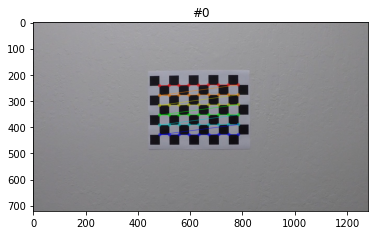

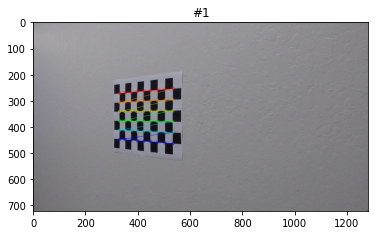

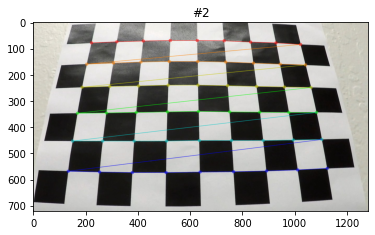

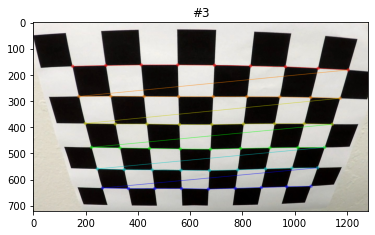

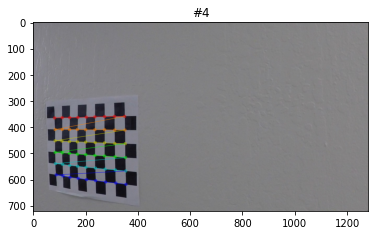

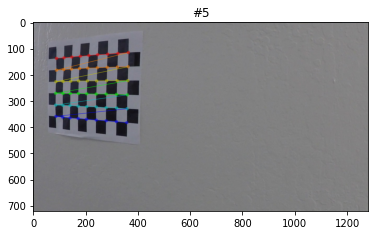

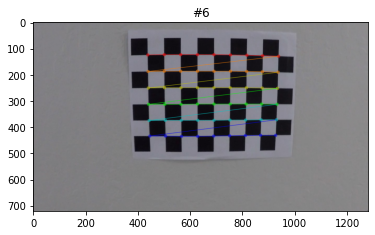

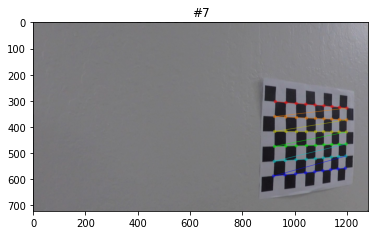

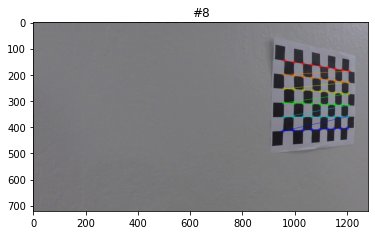

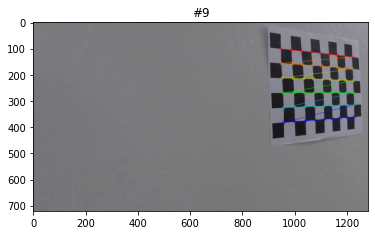

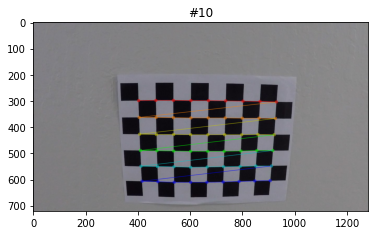

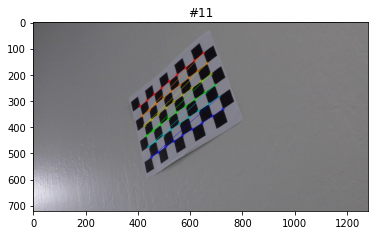

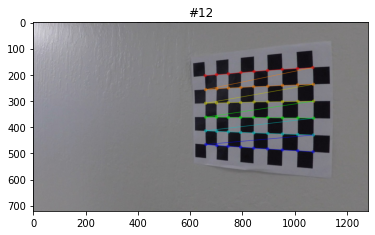

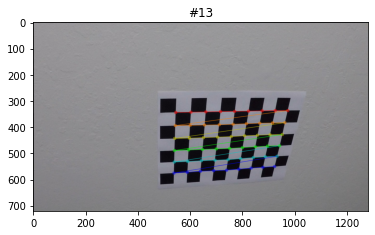

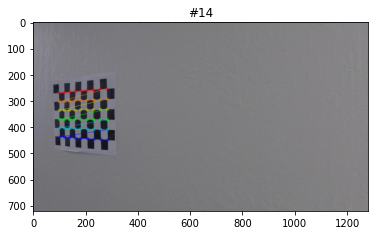

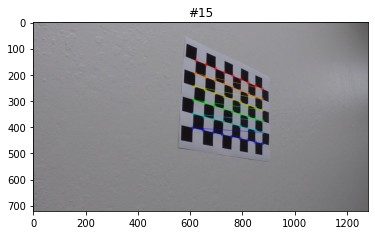

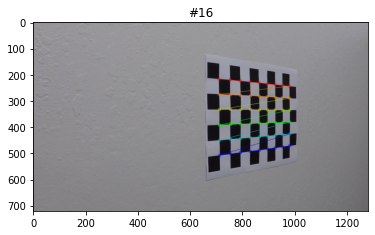

In [4]:
image_paths = glob.glob('materials/camera_cal/calibration*.jpg')
calibrated, matrix, dist = CalibrateImages(image_paths)

# Display calibrated images
for i, img in enumerate(calibrated):
    DisplayImage(img, "#" + str(i))

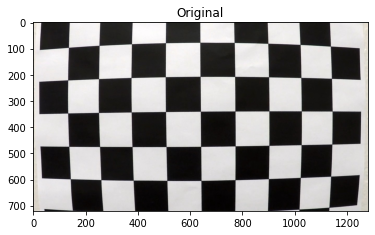

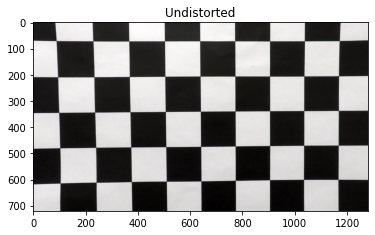

In [5]:
# Undistort calibrated images
def undistort(image, matrix, dist):
    return cv.undistort(image, matrix, dist, None, matrix)

# Undistort test image
chessboard = cv.imread("materials/camera_cal/calibration1.jpg")
undistorted = undistort(chessboard, matrix, dist)
DisplayImage(chessboard, "Original")
DisplayImage(undistorted, "Undistorted")

## Perspective Transform

In [6]:
def perspectiveTransform(image):
    height, width, _ = image.shape

    # Calculate dest verts
    vert1 = [0, 0]
    vert2 = [width, 0]
    vert3 = [0, height]
    vert4 = [width, height]
    destVerts = np.float32([vert1, vert2, vert3, vert4])

    # Calculate src verts
    left = width / 2.25
    top = height / 1.6
    right = width / 1.8
    bottom = height - 20
    offset = left / 1.15

    topLeft = (left, top)
    topRight = (right, top)
    bottomLeft = (left-offset, bottom)
    bottomRight = (right+offset, bottom)
    srcVerts = np.float32([topLeft, topRight, bottomLeft, bottomRight])

    # Calculate warped matrix
    wMatrix = cv.getPerspectiveTransform(srcVerts, destVerts)
    wImg = cv.warpPerspective(image, wMatrix, (width, height))
    return wImg

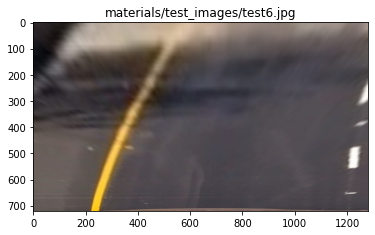

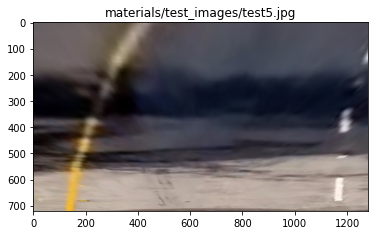

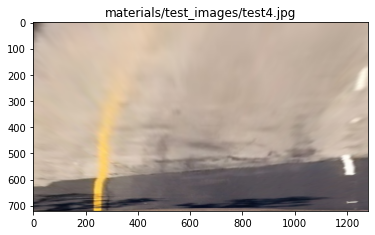

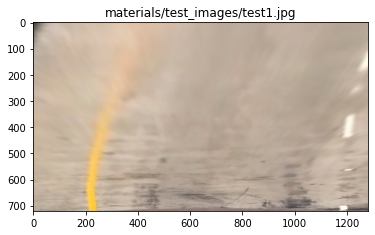

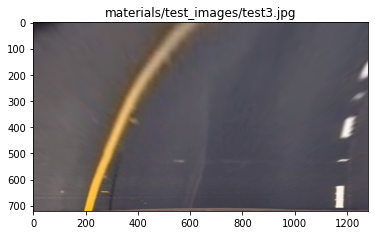

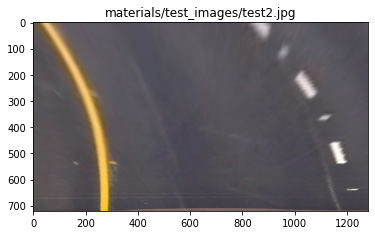

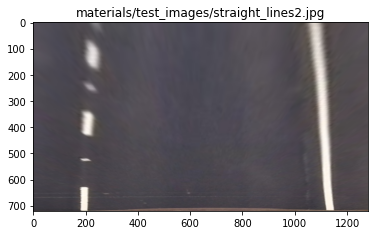

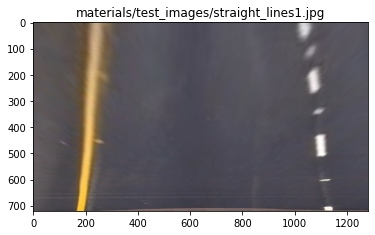

In [7]:
# Test perspective transform on test images
roadImgs = glob.glob("materials/test_images/*.jpg")
for path in roadImgs:
    img = cv.imread(path)

    # Undistort
    undistorted = undistort(img, matrix, dist)

    # Warp
    warped = perspectiveTransform(undistorted)

    DisplayImage(warped, path)

## Image Thresholding

In [34]:
# Invert a channel
def invertChannel(channel):
    height, width = channel.shape
    for x in range(width):
        for y in range(height):
            val = channel[y-1, x-1]
            channel[y-1, x-1] = abs(val - 255)
    return channel

# Select a channel from an image and create a binary thresholded image
def binaryThreshold(img, channel, amplification, threshold):
    extracted = img[:,:,channel]

    # Amplify selected channel for easier detection
    amplified = ((extracted/255) * amplification) * 255

    _, threshold = cv.threshold(amplified, threshold, 255, cv.THRESH_BINARY)
    return threshold

# Combine two thresholded channels (assuming they have the same width & height)
def combineBinaryChannels(channel1, channel2):
    height, width = channel1.shape
    combine = np.zeros((height,width,1), dtype=np.uint8)

    for x in range(width):
        for y in range(height):
            if channel1[y-1, x-1] == channel2[y-1, x-1]:
                combine[y-1, x-1] = channel1[y-1, x-1]
            else:
                combine[y-1, x-1] = 0
    return combine


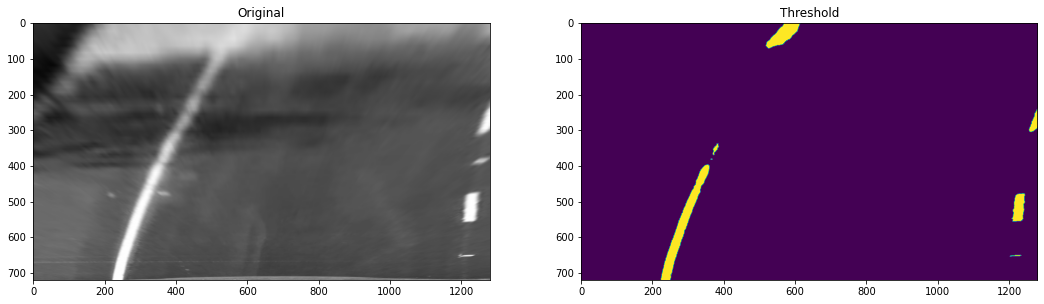

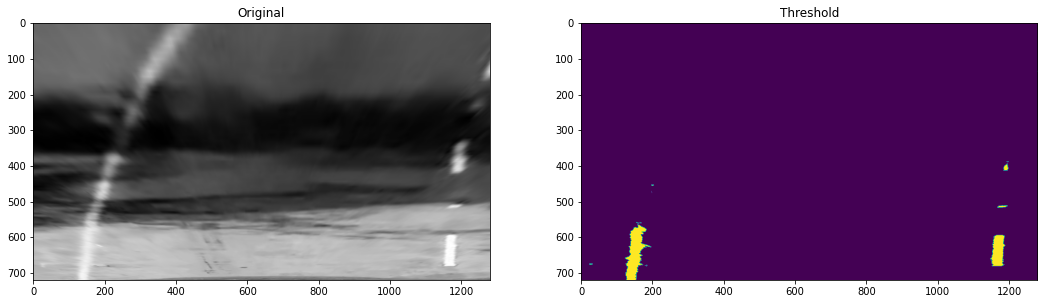

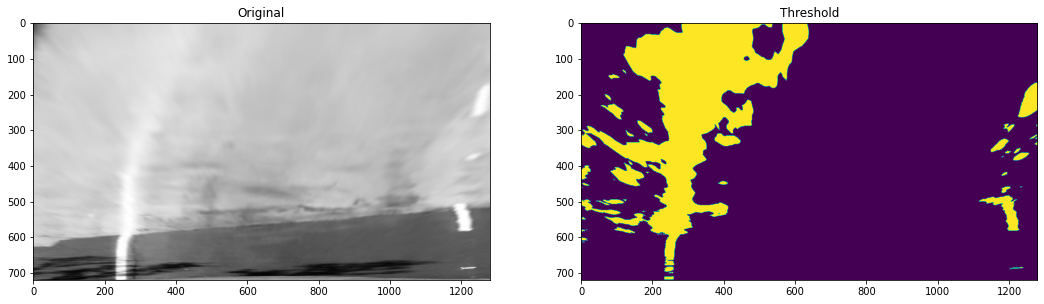

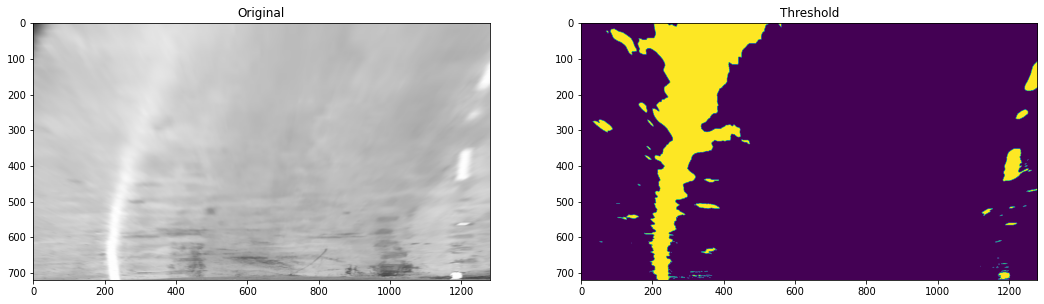

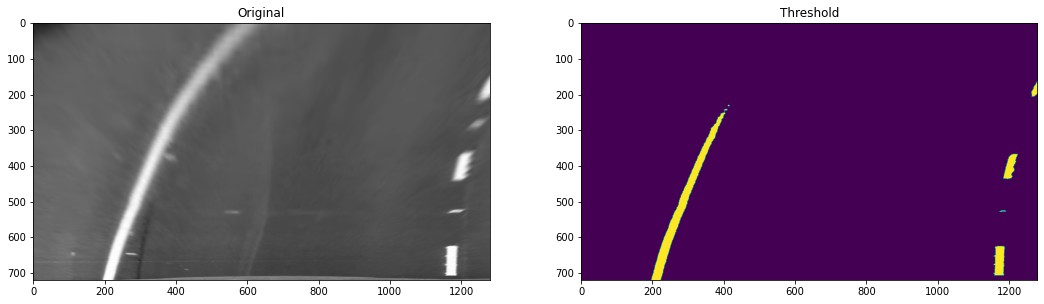

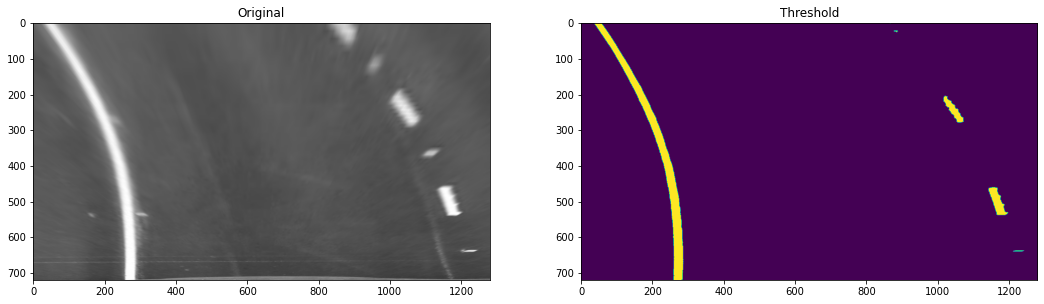

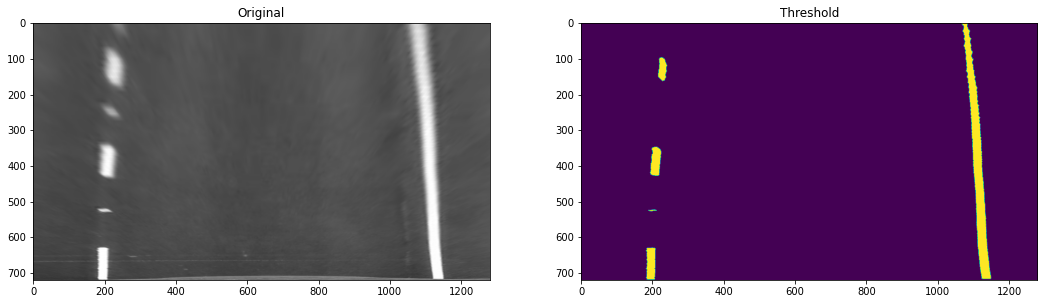

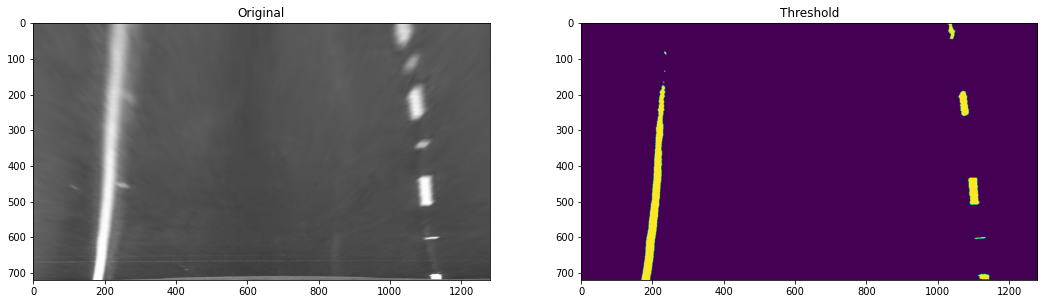

In [60]:
# Test binary thresholding on road images
roadImgs = glob.glob("materials/test_images/*.jpg")
for path in roadImgs:
    img = cv.imread(path)

    # Undistort
    undistorted = undistort(img, matrix, dist)

    # Warp
    warped = perspectiveTransform(undistorted)

    # Isolate red channel
    _, _, r = cv.split(warped)
    redImg = cv.merge([r,r,r])

    # Convert to HLS color space
    hls = cv.cvtColor(redImg, cv.COLOR_BGR2HLS)

    # Threshold
    thresholded = binaryThreshold(hls, 1, 1.08, 230)

    # Display all results
    _, (x1, x2) = plt.subplots(1, 2, figsize=(18, 6))
    x1.imshow(BGR2RGB(redImg))
    x1.set_title("Original")

    x2.imshow(thresholded)
    x2.set_title('Threshold')

## Sobel Operator

In [69]:
def SobelEdges(img, sobelKernelSize=3, gaussianKernelSize=3):
    # Apply Gaussain Blur
    blur = cv.GaussianBlur(img, (gaussianKernelSize, gaussianKernelSize), 0)

    # Apply sobel operator
    sobelX = cv.Sobel(blur, cv.CV_64F, 1, 0, ksize=sobelKernelSize)
    sobelY = cv.Sobel(blur, cv.CV_64F, 0, 1, ksize=sobelKernelSize)
    absX = cv.convertScaleAbs(sobelX)
    absY = cv.convertScaleAbs(sobelY)

    edges = cv.addWeighted(absX, 0.5, absY, 0.5, 0)
    return edges

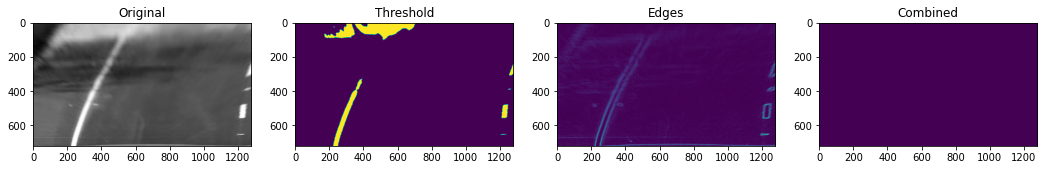

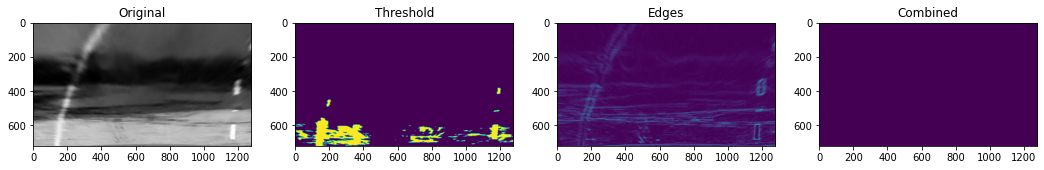

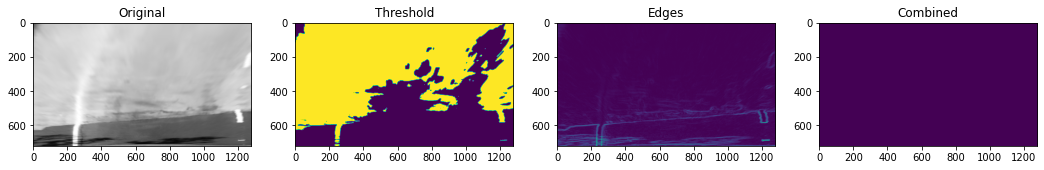

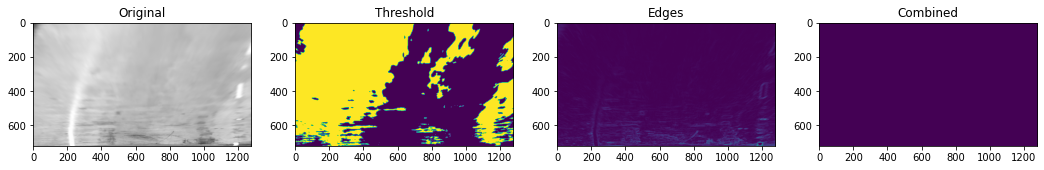

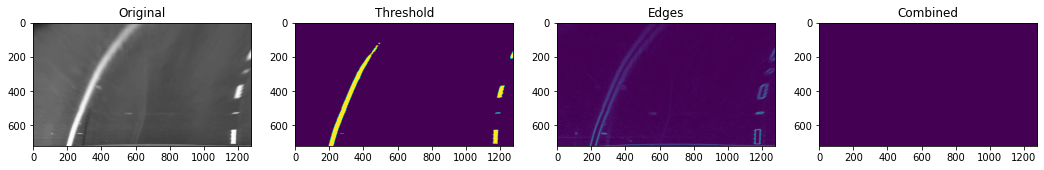

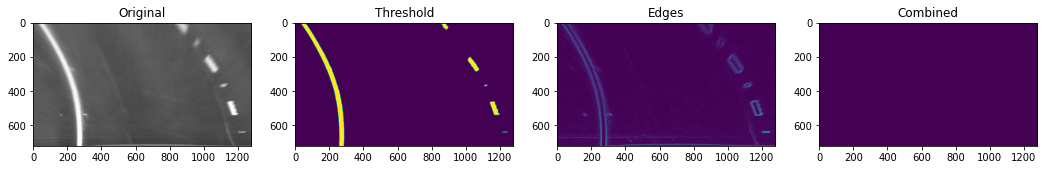

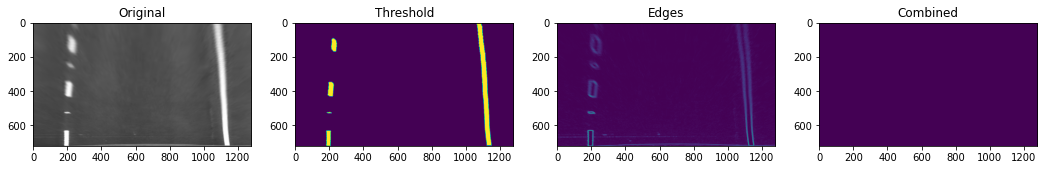

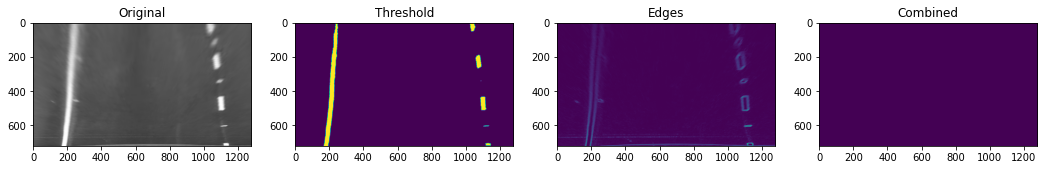

In [72]:
# Test sobel operator on road images
roadImgs = glob.glob("materials/test_images/*.jpg")
for path in roadImgs:
    img = cv.imread(path)

    # Undistort
    undistorted = undistort(img, matrix, dist)

    # Warp
    warped = perspectiveTransform(undistorted)

    # Isolate red channel
    _, _, r = cv.split(warped)
    redImg = cv.merge([r,r,r])

    # Find edges
    edges = SobelEdges(r)
    edgeThreshold = binaryThreshold(edges, )

    # Convert to HLS color space
    hls = cv.cvtColor(redImg, cv.COLOR_BGR2HLS)

    # Threshold
    thresholded = binaryThreshold(hls, 1, 1.2, 230)

    # Combine the two
    combined = combineBinaryChannels(thresholded, edges)

    # Display all results
    _, (x1, x2, x3, x4) = plt.subplots(1, 4, figsize=(18, 6))
    x1.imshow(BGR2RGB(redImg))
    x1.set_title("Original")

    x2.imshow(thresholded)
    x2.set_title('Threshold')

    x3.imshow(edges)
    x3.set_title("Edges")

    x4.imshow(combined)
    x4.set_title("Combined")